In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import random
import time

from tools import kaczmarz_method, sparse
from plot_tools import plotRes, plotErr

import warnings
warnings.filterwarnings('ignore')

In [2]:
#@title : Matplotlib configuration

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}

matplotlib.rc('font', **font)

SMALL_SIZE = 10 
MEDIUM_SIZE = 12 
BIGGER_SIZE = 14 

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['text.usetex'] = True

# activate latex text rendering
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')

plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

In [3]:
# Fixing random state for reproducibility
np.random.seed(1234)

In [4]:
# Create the toy example

# Run this notebook to produce different plots in the paper:
# For noiseless experiments set noiselev = 0.0
#     (m, n) = (100, 20),  R=1 for figure 1
#     (m, n) = (100, 200), R=10 for figure 2
#     (m, n) = (100, 500), R=10 for figure 3
#     (m, n) = (200, 600), R=5 for figure 4
#     (m, n) = (300, 300), R=5 for figure 5

# Run this notebook to produce different plots in the paper:
# For noisy experiments set noiselev = 0.1 and lambda=1
#     (m, n) = (100, 100),  R=5 for figure 13
#     (m, n) = (500, 100), R=5 for figure 14
#     (m, n) = (100, 500), R=5 for figure 15

m = 100 # number of equation
n = 200 # number of unknown
R = 10  # number of repeats

if 6*max(m,n) <=2600:
    max_iter = 6000 
elif 6*max(m,n) > 2600:
    max_iter = 12000 

In [5]:
s = 10  # number of nonzeros in solution

lambda_rk = 0
lambda_rsk = 1

A = np.random.randn(m,n) 
x_true = sparse(np.random.randn(n,1),s)

noiselev = 0.0

b = A @ x_true

noise = np.random.randn(m,1)
noise = noise/np.linalg.norm(noise)

b_noisy = b + noiselev*noise

print(A.shape, x_true.shape, b.shape, s)

(100, 200) (200, 1) (100, 1) 10


In [6]:
# Check
_, S1, _ = np.linalg.svd(A, full_matrices=True)


if 2*S1[0] <= (sum(np.linalg.norm(A, axis=1) ** 2) * s)/(s + 2*lambda_rsk) :
    print('The RSK method with averaging will be faster than the non-sparse RK method')
else:
    print('The RSK method with averaging will not be faster than the non-sparse RK method')

The RSK method with averaging will be faster than the non-sparse RK method


# Randomized Kaczmarz

In [8]:
W_rk = [1 for _ in range(m)]
eta_rk = 1

x_rk, residuals_rk, errors_rk = np.zeros((R, n, 1)), np.zeros((R, max_iter)), np.zeros((R, max_iter))
start = time.time()
for r in range(R):
    x, residuals, errors = kaczmarz_method(A, b, eta_rk, x_true, W_rk, max_iter, bN=b_noisy, lbda=lambda_rk)
    x_rk[r] = x
    residuals_rk[r] = residuals
    errors_rk[r] = errors

end = time.time()
print(f'The total time for RK is {end - start}')

The total time for RK is 25.580460786819458


# Randomized Sparse Kaczmarz

In [9]:
W_rsk = [1 for _ in range(m)]
eta_rsk = 1

x_rsk, residuals_rsk, errors_rsk = np.zeros((R, n, 1)), np.zeros((R, max_iter)), np.zeros((R, max_iter))
start = time.time()
for r in range(R):
    x, residuals, errors = kaczmarz_method(A, b, eta_rsk,  x_true, W_rsk, max_iter, bN=b_noisy, lbda=lambda_rsk)
    x_rsk[r] = x
    residuals_rsk[r] = residuals
    errors_rsk[r] = errors

end = time.time()
print(f'The total time for RSK is {end - start}')

The total time for RSK is 29.847556114196777


# Randomized Sparse Kaczmarz with Averaging

### v1 : RSKA with $W=I$, $\quad $ with a coupling such that $PWD^{-2}= \frac{\alpha I}{\|A\|^2_F}$ $\,\,$ i.e $\,\,$ $p_i = \frac{\|a_i\|^2_2}{\|A\|^2_F}$, $\quad$ $\eta = 1+ \frac{min(n,m)}{10} $

In [10]:
W_rska = [1 for _ in range(m)]
eta_rska = int(min(n,m)/10) + 1

x_rska, residuals_rska, errors_rska = np.zeros((R, n, 1)), np.zeros((R, max_iter)), np.zeros((R, max_iter))
start = time.time()
for r in range(R):
    x, residuals, errors = kaczmarz_method(A, b, eta_rska,  x_true, W_rska, max_iter, bN=b_noisy, lbda=lambda_rsk, change_proba=True)
    x_rska[r] = x
    residuals_rska[r] = residuals
    errors_rska[r] = errors

end = time.time()
print(f'The total time for RSKA is {end - start}')

The total time for RSKA is 43.05697536468506


### v2 : RSKA with a general weight matrix $W = \alpha^* I$, $\quad$ i.e $\,\,$ $p_i = \frac{\|a_i\|^2_2}{\|A\|^2_F}$, $\quad$ $\eta = 1+ \frac{min(n,m)}{10} $

In [11]:
# Uniform weights
eta_rska1 = int(min(n,m)/10) + 1
c_proba = True

squared_row_norms = np.linalg.norm(A, axis=1) ** 2
Fnorm = squared_row_norms.sum()

_, max_A, _ = np.linalg.svd(A, full_matrices=True)

smax = max_A[0]**2/Fnorm
smin = max_A[-1]**2/Fnorm
eta_opt = int(np.ceil(1/smax))

if (smax - smin) <= 1/(eta_rska1 - 1):
    print('On the first case')
    alpha_rska1 = eta_rska1/(1 + (eta_rska1-1)*smax)
    print(f' alpha = {alpha_rska1}, eta = {eta_rska1}, eta_opt = {np.ceil(1/smax)}')

elif (smax - smin) > 1/(eta_rska1 - 1):
    print('On the second case')
    alpha_rska1 = (2*eta_rska1)/(1 + (eta_rska1-1)*(smin+smax))
    print(f' alpha = {alpha_rska1}, eta = {eta_rska1}, eta_opt = {np.ceil(1/smax)}')

W_rska1 = [alpha_rska1 for _ in range(m)]

x_rska1, residuals_rska1, errors_rska1 = np.zeros((R, n, 1)), np.zeros((R, max_iter)), np.zeros((R, max_iter))
start = time.time()
for r in range(R):
    x, residuals, errors = kaczmarz_method(A, b, eta_rska1,  x_true, W_rska1, max_iter, bN=b_noisy, lbda=lambda_rsk, change_proba=c_proba)
    x_rska1[r] = x
    residuals_rska1[r] = residuals
    errors_rska1[r] = errors

end = time.time()
print(f'The total time for RSKA-v1 is {end - start}')

On the first case
 alpha = 8.687465052030287, eta = 11, eta_opt = 38.0
The total time for RSKA-v1 is 42.520554542541504


### v3 : RSKA with a general weight matrix $W$, $\quad$ $p_i = \frac{\|a_i\|^2_2}{\|A\|^2_F}$, $\quad$ $q = 1+ \frac{min(n,m)}{10} $

In [12]:
eta_rska2 = int(min(n,m)/10) + 1

W_rska2 = np.random.uniform(0,1,m)
print(eta_rska2, np.max(W_rska2)/2)

x_rska2, residuals_rska2, errors_rska2 = np.zeros((R, n, 1)), np.zeros((R, max_iter)), np.zeros((R, max_iter))
start = time.time()
for r in range(R):
    x, residuals, errors = kaczmarz_method(A, b, eta_rska2,  x_true, W_rska2, max_iter, bN=b_noisy, lbda=lambda_rsk)
    x_rska2[r] = x
    residuals_rska2[r] = residuals
    errors_rska2[r] = errors

end = time.time()
print(f'The total time for RSKA-v2 is {end - start}')

11 0.49904154851999694
The total time for RSKA-v2 is 48.7786705493927


### v4 : RSKA with a general weight matrix $W$, $\quad$ with a coupling such that $PWD^{-2}= \frac{\alpha I}{\|A\|^2_F}$, $\quad$ $\eta = 1+ \frac{min(n,m)}{10} $

In [13]:
# General distribution of weights.
eta_rska3 = int(min(n,m)/10) + 1
c_proba = False

W_rska3 = np.random.uniform(0,0.1,m)
print(eta_rska3, np.max(W_rska3)/2)

x_rska3, residuals_rska3, errors_rska3 = np.zeros((R, n, 1)), np.zeros((R, max_iter)), np.zeros((R, max_iter))
start = time.time()
for r in range(R):
    x, residuals, errors = kaczmarz_method(A, b, eta_rska3,  x_true, W_rska3, max_iter, bN=b_noisy, lbda=lambda_rsk, change_proba=c_proba)
    x_rska3[r] = x
    residuals_rska3[r] = residuals
    errors_rska3[r] = errors

end = time.time()
print(f'The total time for RSKA-v3 is {end - start}')

11 0.04984953802134189
The total time for RSKA-v3 is 55.14321684837341


# Residuals

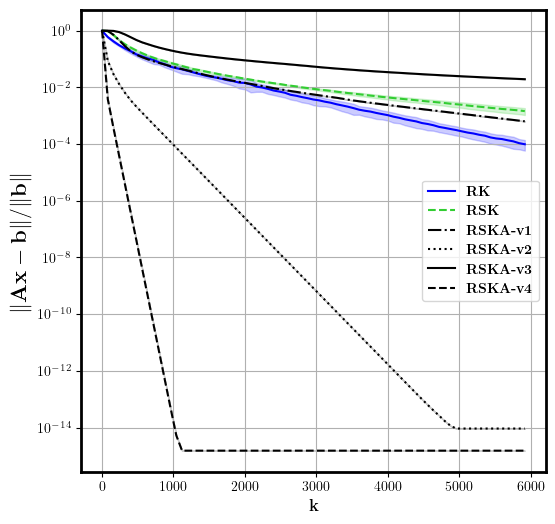

In [14]:
plotRes([residuals_rk, residuals_rsk, residuals_rska, residuals_rska1, residuals_rska2, residuals_rska3], s=80)

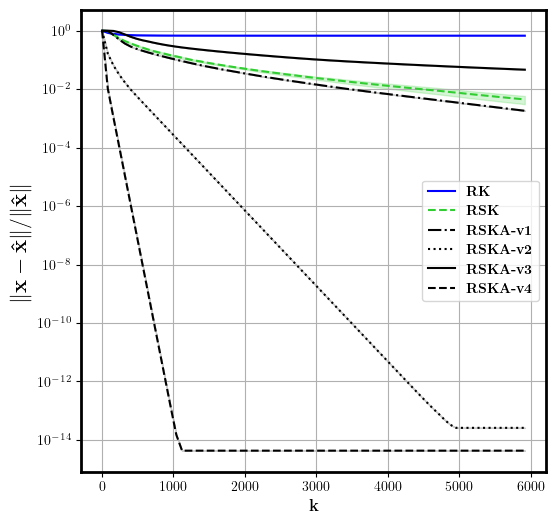

In [15]:
plotErr([errors_rk, errors_rsk, errors_rska, errors_rska1, errors_rska2, errors_rska3], s=80)